In [1]:
!pip install tqdm==4.66.1
!pip install datasets==2.14.6
!pip install transformers==4.35.2
!pip install torch==2.1.0
!pip install torchsummary==1.5.1
!pip install torchvision==0.16.0
!pip install Pillow==10.0.1

In [2]:
import os
import pandas as pd
from datasets import Dataset
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
! gdown 1TSYIdXmhFxvjoclZuqcMrvcYXXFk0w6W
! wget --no-clobber https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip
! wget --no-clobber https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip
! unzip -o -q images.zip
! unzip -o -q images2.zip
!mkdir /content/images
!find /content/VG_100K -type f -exec mv -t /content/images/ {} +
!find /content/VG_100K_2 -type f -exec mv -t /content/images/ {} +
!pip -qqq install datasets

Downloading...
From (original): https://drive.google.com/uc?id=1TSYIdXmhFxvjoclZuqcMrvcYXXFk0w6W
From (redirected): https://drive.google.com/uc?id=1TSYIdXmhFxvjoclZuqcMrvcYXXFk0w6W&confirm=t&uuid=9cd2b448-a094-47f7-82ec-287470deb8c4
To: /content/visualgenome_AR.csv
100% 209M/209M [00:01<00:00, 119MB/s]
--2024-03-25 01:24:44--  https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9731705982 (9.1G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   9.06G  17.1MB/s    in 9m 25s  

2024-03-25 01:34:10 (16.4 MB/s) - ‘images.zip’ saved [9731705982/9731705982]

--2024-03-25 01:34:10--  https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.

In [5]:
df = pd.read_csv("visualgenome_AR.csv")

In [6]:
df_N = df.iloc[0:1000]

In [7]:
dataset = Dataset.from_pandas(df_N)

In [8]:
dataset

Dataset({
    features: ['question_en', 'answer_en', 'image_id', 'qa_id', 'image_path', 'question_ar', 'answer_ar'],
    num_rows: 1000
})

In [9]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        question = item['question_en']
        answer = item['answer_en']
        image_path = item['image_path']
        image = Image.open(image_path).convert("RGB")
        encoding = self.processor(image, question, return_tensors="pt")
        labels = self.processor.tokenizer(answer, max_length=8, padding='max_length', truncation=True, return_tensors="pt").input_ids
        encoding = {key: val.squeeze() for key, val in encoding.items()}
        encoding['labels'] = labels.squeeze()
        return encoding


In [10]:
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = VQADataset(dataset=train_test_split['train'], processor=BlipProcessor.from_pretrained("Salesforce/blip-vqa-base"))
valid_dataset = VQADataset(dataset=train_test_split['test'], processor=BlipProcessor.from_pretrained("Salesforce/blip-vqa-base"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = [item['labels'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100) # -100 is often used as ignore_index in loss computations

    new_batch = {
        'input_ids': input_ids_padded,
        'pixel_values': pixel_values,
        'labels': labels_padded
    }
    return new_batch

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)


In [13]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [14]:
num_epochs = 3


In [15]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()


    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_dataloader)}")

Training Epoch 1:   0%|          | 0/113 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1, Loss: 5.277230863022593


Training Epoch 2:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2, Loss: 1.7366903756572083


Training Epoch 3:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3, Loss: 1.6189996193995517


In [16]:
model.eval()  # Set the model to evaluation mode
validation_loss = 0
with torch.no_grad():  # No need to track gradients for validation
    for batch in tqdm(valid_dataloader, desc="Validation"):
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        validation_loss += loss.item()

print(f"Validation Loss: {validation_loss / len(valid_dataloader)}")


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 2.0397587281007032


In [17]:
from transformers import BlipProcessor

# Initialize the processor with the pretrained model you're using
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")


In [18]:
# Save the model
model_save_path = "/content/my_fine_tuned_model.bin"
torch.save(model.state_dict(), model_save_path)

# Save the processor
processor_save_path = "/content/my_processor"
processor.save_pretrained(processor_save_path)


In [19]:
from transformers import BlipProcessor, BlipForQuestionAnswering
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = BlipProcessor.from_pretrained(processor_save_path)

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", state_dict=torch.load(model_save_path))
model = model.to(device)
model.eval()


BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [20]:

# def predict_answer(model, processor, image_path, question, device):
#     image = Image.open(image_path).convert("RGB")

#     inputs = processor(image, question, return_tensors="pt")
#     inputs = {k: v.to(device) for k, v in inputs.items()}

#     with torch.no_grad():
#         answer_ids = model.generate(input_ids=inputs['input_ids'],
#                                     attention_mask=inputs['attention_mask'],
#                                     pixel_values=inputs['pixel_values'])

#     answer = processor.decode(answer_ids[0], skip_special_tokens=True)

#     print(f"Question: {question}\nPredicted answer: {answer}")

In [36]:
def predict_answer(model, processor, image_path, question, device):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(image, question, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            answer_ids = model.generate(input_ids=inputs['input_ids'],
                                        attention_mask=inputs['attention_mask'],
                                        pixel_values=inputs['pixel_values'])
        answer = processor.decode(answer_ids[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error in generating answer: {e}")
        answer = "Unable to generate an answer."  # Default fallback answer

    return answer


In [ ]:

image_path = '/content/test_1.jpg'
question = 'Who is holding the dog?'

predict_answer(model, processor, image_path, question, device)


Question: Who is holding the dog?
Predicted answer: a woman.


In [ ]:
image_path = '/content/test_1.jpg'
question = 'what is the girl holding?'

predict_answer(model, processor, image_path, question, device)

Question: what is the girl holding?
Predicted answer: teddy bear.


In [ ]:
image_path_2 = '/content/test_2.jpg'
question_2 = 'What is this place'

predict_answer(model, processor, image_path_2, question_2, device)


Question: What is this place
Predicted answer: playground.


In [ ]:
image_path_2 = '/content/test_2.jpg'
question_2 = 'What are the color of the slides?'

predict_answer(model, processor, image_path_2, question_2, device)


Question: What are the color of the slides?
Predicted answer: red.


In [ ]:
image_path_3 = '/content/test_3.jpg'
question_3 = 'What is the unifrom color of the students?'

predict_answer(model, processor, image_path_3, question_3, device)


Question: What is the unifrom color of the students?
Predicted answer: blue.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [22]:
!pip install googletrans==4.0.0-rc1


In [37]:
from googletrans import Translator, LANGUAGES

translator = Translator()

def translate_ar_to_en(question_in_arabic):
    translation = translator.translate(question_in_arabic, src='ar', dest='en')
    return translation.text

def translate_en_to_ar(answer_in_english):
    translation = translator.translate(answer_in_english, src='en', dest='ar')
    return translation.text


In [38]:
# def predict_and_translate(model, processor, image_path, question_in_arabic, device):
#     # Translate the question from Arabic to English
#     question_in_english = translate_ar_to_en(question_in_arabic)

#     # Predict the answer in English
#       # This function needs modification to return the answer instead of printing

#     # Assuming `predict_answer` is modified to return the answer in English
#     answer_in_english = predict_answer(model, processor, image_path, question_in_english, device)

#     # Translate the answer back to Arabic
#     answer_in_arabic = translate_en_to_ar(answer_in_english)

#     print(f"Question (AR): {question_in_arabic}")
#     print(f"Answer (AR): {answer_in_arabic}")


In [39]:
def predict_and_translate(model, processor, image_path, question_in_arabic, device):
    if not question_in_arabic.strip():
        print("The Arabic question is empty.")
        return

    question_in_english = translate_ar_to_en(question_in_arabic)
    if not question_in_english.strip():
        print("Translation to English failed.")
        return

    answer_in_english = predict_answer(model, processor, image_path, question_in_english, device)
    if not answer_in_english.strip():
        print("No answer generated.")
        return

    answer_in_arabic = translate_en_to_ar(answer_in_english)
    if not answer_in_arabic.strip():
        print("Translation to Arabic failed.")
        return

    print(f"Question (AR): {question_in_arabic}")
    print(f"Answer (AR): {answer_in_arabic}")


In [42]:
from PIL import Image
import matplotlib.pyplot as plt

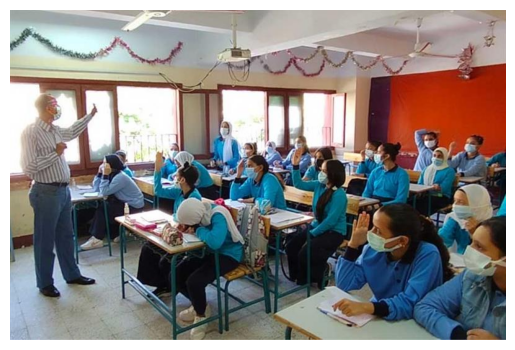

In [43]:
image_path = "/content/test_3.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes ticks
plt.show()

In [40]:
image_path = "/content/test_3.jpg"
question_in_arabic = "ما هو لون ملابس الطلاب؟"

predict_and_translate(model, processor, image_path, question_in_arabic, device)


Question (AR): ما هو لون ملابس الطلاب؟
Answer (AR): أزرق.
